# Определение возраста покупателей

## Исследовательский анализ данных

Для начала импортируем необходимые для работы инструменты

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

Прочитаем файл и сохраним его в переменной

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels_datagen = ImageDataGenerator(rescale=1./255)
labels_gen_flow = labels_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Оценим размер датасета

In [3]:
print(labels.shape)

(7591, 2)


Посмотрим общую информацию о нём

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датасете нет пропусков, в первом столбце хранится фотография человека, во втором указан его возраст. Всего в таблице 7591 фотографий.

Выведем пять первых строк таблицы на экран

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Так как в нашем распоряжении датасет с фотографиями, то нужно использовать другой метод, сейчас мы можем только видеть название фотографии и возраст изображённого на ней человека.

Для начала посмотрим на распределение возраста в таблице.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


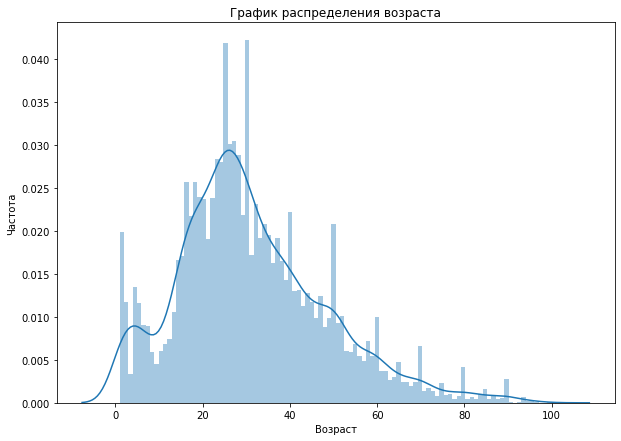

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
sns.distplot(labels['real_age'], ax=ax, bins=100)
ax.set_title('График распределения возраста')
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
plt.show()

На графике заметно увеличение количества "круглых" лет возраста. Возможно, округлили возраст до ближайшего "круглого" числа.

Построим ящик с усами

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='real_age'>

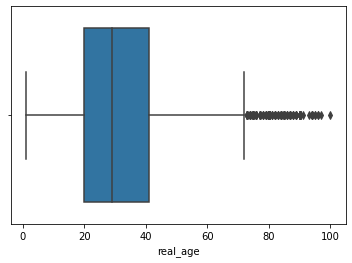

In [7]:
sns.boxplot(labels["real_age"])

Мы видим, что в выборке большинство людей в возрасте от 20 до 40 лет. Медианное значение на отметке чуть меньше 30 лет. Также заметили увеличение "круглых" дат возраста, возможно, его округляли. Ящик с усами показывает выбросы, но мы не будем удалять данные, так как возраст выглядит реальным. Некоторые сомнения вызывает возраст около ста лет, но встречаются и долгожители, их фотографии вполне могли попасть в выборку.

Разделим выборку на обучающую и тестовую.

In [8]:
features, target = next(labels_gen_flow)

Оценим её размер

In [9]:
features.shape

(32, 224, 224, 3)

Выведем изображения на экран, удалим оси х и у, так как для восприятия фотографий они не нтребуются.

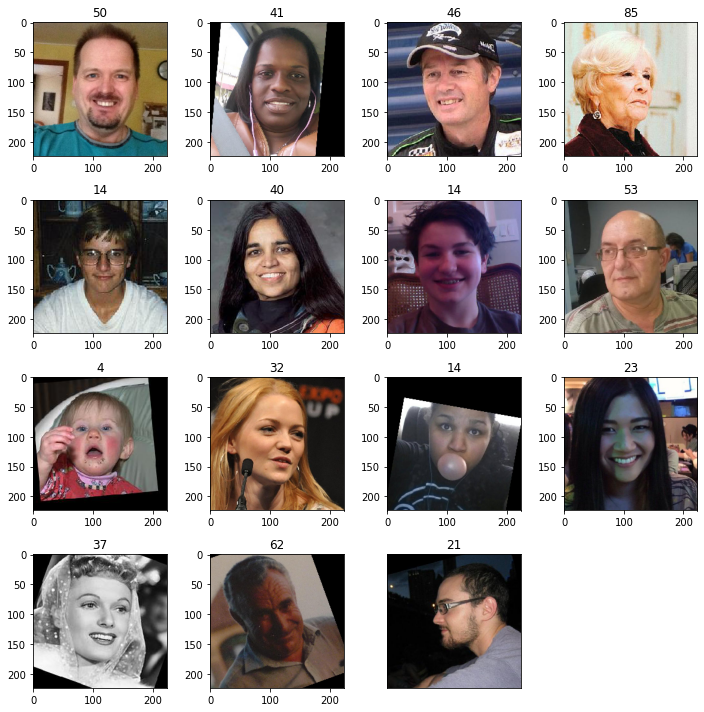

In [10]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.title(target[i])
plt.xticks([])
plt.yticks([])
plt.tight_layout()

Итак, в таблице хранится 7591 фотографий разных людей, мы видим людей разных возрастов, присутствует даже фото ребёнка. На некоторых фотографиях видна только часть лица, человек стоит/сидит боком к камере. Также присутствуют старые чёрно-белые изображения. Некоторые фотографии повёрнуты примерно на 45 градусов.

Так как освещение, цвет, небольшие повороты, обзор фотографий различается, некоторые предметы закрывают часть лица (например пузырь из жвачки), то это может не слишком хорошо сказаться на обучении модели. Хотя такие фотографии наиболее приблежены к реальным данным.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 


# In[ ]:


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


# In[ ]:


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
        rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


# In[ ]:


def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model


# In[ ]:


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 48s - loss: 266.8433 - mae: 11.5205 - val_loss: 798.3053 - val_mae: 23.3471
Epoch 2/5
178/178 - 38s - loss: 76.1266 - mae: 6.5326 - val_loss: 395.1364 - val_mae: 14.8002
Epoch 3/5
178/178 - 38s - loss: 49.9852 - mae: 5.3799 - val_loss: 264.3265 - val_mae: 11.9375
Epoch 4/5
178/178 - 38s - loss: 35.7251 - mae: 4.5360 - val_loss: 151.6620 - val_mae: 9.5467
Epoch 5/5
178/178 - 38s - loss: 27.8101 - mae: 4.0567 - val_loss: 90.3228 - val_mae: 7.1937
60/60 - 9s - loss: 90.3228 - mae: 7.1937
Test MAE: 7.1937

```

## Анализ обученной модели

Для обучения мы использовали модель ResNet, так как она обучена на более чем 1 миллионе изображений из базы данных ImageNet. Мы добавили несколько слоёв, чтобы создать качественную модель.
При обучении модели мы добились значения MAE на уровне 4.0567 на обучающей выборке и 7.1937 на тестовой.

Задача состояла в том, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя. Модель имеет погрешность в 7 лет, это не так много, но при продаже алкоголя необходимо, чтобы кассир тоже проверял возраст. У нашей модели, которая по фотографии определяет приблизительный возраст человека, хорошее качество. Можно ещё поэксперементировать с количеством эпох при обучении, возможно, результат получится улучшить.